In [1]:
# Import libraries
import pandas as pd
import numpy as np

import datetime

from sklearn.feature_extraction import text, stop_words
import requests
import string
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import SMOTE

import warnings; warnings.simplefilter('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
# Increase size of dataframe
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 5000)

In [3]:
# read historical tweets data
data = pd.read_csv ('./Aruna/data/historic_tweets_04212019.csv')

In [4]:
# see what the data looks like
data.head(2)

,Unnamed: 0,date,geo,hashtags,id,text,type,username
0,0,2019-04-13 23:02:31+00:00,NaN,#RedCross,1117201425581445120,As part of the Stamps Scholars 2019 Natl. Conv...,official,GARedCross
1,1,2019-04-13 17:29:29+00:00,NaN,NaN,1117117616827641856,Thanks for your support! All eligible donors c...,official,GARedCross


### Data Cleaning

In [5]:
# Identify tweets within Florence time period 9/10-9/30/2018

# split date into date and time
data['date'] = data['date'].map(lambda x: str(x.split('+')[0]))

# convert object to datetime object
data['date'] = pd.to_datetime(data['date'])

start_date = datetime.datetime(2018,9,10)
end_date = datetime.datetime(2018,9,30)

data = data[(data['date'] >= start_date) & (data['date'] < end_date)]

In [6]:
# drop columns 'Unnamed: 0 'and 'geo'; geo has all null values; hashtags has 50% null values
data.drop(columns = ['Unnamed: 0', 'geo', 'hashtags', 'id', 'type', 'username'], inplace=True)

In [7]:
# drop rows where text is null
data.dropna(subset=['text'], inplace=True) 

In [8]:
# Drop duplicates
data.drop_duplicates(subset=['text'],inplace=True )

In [9]:
data.shape

(7693, 2)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7693 entries, 293 to 142984
Data columns (total 2 columns):
date    7693 non-null datetime64[ns]
text    7693 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 180.3+ KB


In [11]:
data.head(2)

,date,text
293,2018-09-28 20:25:39,Thank you to all our #GARedCross volunteers on...
294,2018-09-28 16:16:55,"#RedCross volunteers, Don Dyksterhouse of N.C...."


#### data is clean

### Prepare data for NLP model

In [12]:
# Change case of all words to lower
data['text'] = [i.lower() for i in data['text']]

In [13]:
# Use Regular Expressions to remove references to indvidual accounts starting with @
data['text'] = [re.sub(r'@[A-z0-9]*', r' ', i) 
                    for i in data['text']];

# Use Regular Expressions to remove all punctuations 
data['text'] = [re.sub('[^A-Za-z0-9#]+', ' ', i) 
                    for i in data['text']];

In [14]:
# Lemmatize the string and then join it back
lm = WordNetLemmatizer()
data['text'] = [" ".join([lm.lemmatize(w) for w in i.split()]) 
                   for i in data['text']];

### Identify road closures based on key words

In [15]:
# Create a list of words to filter
word_list1 = ['road', 'street','rd', 'hwy', 'highway', 'ave', 'avenue','intersection']
word_list2 = ['closed','closure', 'blocked', 'flooded']
not_word_list = ['lane closed', 'lane closure','cleared', 're opened', 'reopen']

In [16]:
data['is_road_closure'] = data['text'].map(lambda x: 1 if ((any(word in x for word in word_list1))
                                                           & (any(word in x for word in word_list2))
                                                           & (not any(word in x for word in not_word_list))
                                                          ) else 0)

In [17]:
data['is_road_closure'].value_counts()

0    7344
1     349
Name: is_road_closure, dtype: int64

In [18]:
# Create a new dataframe with only road closure tweets
data_closures = data[data['is_road_closure'] == 1]
data_closures.shape

(349, 3)

### Save clean data to csv file

In [19]:
data_closures.to_csv('./clean_roadclosure_tweets04252019pm.csv', header = True )

In [20]:
data.to_csv('./clean_hist_tweets04252019pm.csv', header = True )

## Model Prep

#### Create stop_words

In [21]:
# Create my_stop_words in case we want to add additional words 
my_stop_words = list(stop_words.ENGLISH_STOP_WORDS) + ['http','https', 'twitter',
                                                       'com', 'pic', 'www', 'florence', 'florencenc',
                                                       'hurricaneflorence','ly', 'gov', 'drivenc', 'scwx', 'wsoctv']

#### Function to fit model using Pipeline and Gridsearch

In [22]:
def model_fit_score(X, y,
                    vect_name, vect_type=TfidfVectorizer(),
                    model_name='Log_Reg',
                    model_type=LogisticRegression(),
                    parameters={}):

    pipe = Pipeline([
        (vect_name,vect_type),
        (model_name, model_type)])
    
    # perform gridsearch
    grid = GridSearchCV(pipe, param_grid=parameters, scoring='roc_auc', cv=3)
    grid = grid.fit(X, y)

    # Print best attributes
    print(f"For model: {model_name}")
    print("-" * 40)
    print(f"The best parameters are: \n {grid.best_params_}")
    print("-" * 40)
    print(f"The best score is: \n {grid.best_score_:.4f}")
    print("-" * 40)
    
    return grid

#### Function to generate confusion matrix

In [23]:
# from Stack overflow
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Function to predict based on a text

In [24]:
# from Matt Parker
def Probaplot(string,class_1, class_0, model):
    print_dict = {1:class_1,0:class_0}
    df = pd.DataFrame(model.predict_proba([string]),columns= [class_0,class_1],index = ["Probability"]).T
    f,ax = plt.subplots(figsize=(8,5))
    sns.barplot(y = df["Probability"],x=df.index,ax=ax)
    plt.title(string,fontsize=20)

#### Function to calculate sensitivity and specificity

In [25]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

<Figure size 720x504 with 0 Axes>

#### Calculate Baseline Accuracy

In [29]:
data['is_road_closure'].value_counts()

0    7344
1     349
Name: is_road_closure, dtype: int64

#### Perform train-test split on DATA 

In [30]:
# Define features, X, and y
features = ['text']
X = data[features]
y = data['is_road_closure']

In [31]:
# Perform train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y)

In [32]:
# Hardcoding optimal parameters so the code runs faster
params_vec = {
    'vec__max_features': [200],
    'vec__min_df': [.01],
    'vec__max_df': [.8],
    'vec__ngram_range': [(1,2)],
    'vec__stop_words': [my_stop_words]}

params_Log_Reg = {
    'Log_Reg__penalty': ['l1'],
    'Log_Reg__C': [1.0]}

params_gb = {
    'gb__learning_rate': [0.1],
    'gb__n_estimators': [200],
    'gb__max_depth': [5],
    'gb__min_samples_leaf': [1],
    'gb__min_samples_split': [2]}
    
params_sm = {
    'sm__kind': 'regular',
    'sm__sampling_strategy': [0.45],
    'sm__k_neighbors': [6]}

### Optimize Model 1: Logistic Regression, CountVectorizer

In [33]:
# Call function to fit the model
Log_Reg_cvec = model_fit_score(X_train['text'], y_train,         
                vect_name = 'vec',
                vect_type = CountVectorizer(),               
                model_name ='Log_Reg',          
                model_type = LogisticRegression(),
                parameters = {**params_vec, **params_Log_Reg})

# Print Training and Test scores 
print(f"Train set Score: \n {Log_Reg_cvec.score(X_train['text'], y_train)}")
print(f"Test set Score: \n {Log_Reg_cvec.score(X_test['text'], y_test)}")

For model: Log_Reg
----------------------------------------
The best parameters are: 
 {'Log_Reg__C': 1.0, 'Log_Reg__penalty': 'l1', 'vec__max_df': 0.8, 'vec__max_features': 200, 'vec__min_df': 0.01, 'vec__ngram_range': (1, 2), 'vec__stop_words': ['should', 'during', 'amoungst', 'also', 'keep', 'on', 'moreover', 'three', 'un', 'other', 'six', 'when', 'together', 'five', 'amount', 'wherever', 'hereafter', 'might', 'neither', 'whereby', 'by', 'hereupon', 'interest', 'same', 'etc', 'who', 'next', 'toward', 'forty', 'ourselves', 'which', 'go', 'anywhere', 'hence', 'you', 'hasnt', 'are', 'con', 'become', 'him', 'am', 'eleven', 'most', 'elsewhere', 'these', 'whether', 're', 'give', 'front', 'within', 'name', 'part', 'and', 'up', 'while', 'do', 'somehow', 'thus', 'move', 'since', 'cannot', 'none', 'one', 'due', 'yet', 'whither', 'to', 'done', 'inc', 'that', 'towards', 'now', 'nobody', 'everything', 'being', 'once', 'alone', 'herein', 'is', 'else', 'each', 'until', 'he', 'several', 'whole', 't

### Optimize Model 2: Logistic Regression, TfidfVectorizer

In [34]:
# Call function to fit the model
Log_Reg_tvec = model_fit_score(X_train['text'], y_train,         
                vect_name = 'vec',
                vect_type = TfidfVectorizer(),               
                model_name ='Log_Reg',          
                model_type = LogisticRegression(),
                parameters = {**params_vec, **params_Log_Reg})

# Print Training and Test scores 
print(f"Train set Score: \n {Log_Reg_tvec.score(X_train['text'], y_train)}")
print(f"Test set Score: \n {Log_Reg_tvec.score(X_test['text'], y_test)}")

For model: Log_Reg
----------------------------------------
The best parameters are: 
 {'Log_Reg__C': 1.0, 'Log_Reg__penalty': 'l1', 'vec__max_df': 0.8, 'vec__max_features': 200, 'vec__min_df': 0.01, 'vec__ngram_range': (1, 2), 'vec__stop_words': ['should', 'during', 'amoungst', 'also', 'keep', 'on', 'moreover', 'three', 'un', 'other', 'six', 'when', 'together', 'five', 'amount', 'wherever', 'hereafter', 'might', 'neither', 'whereby', 'by', 'hereupon', 'interest', 'same', 'etc', 'who', 'next', 'toward', 'forty', 'ourselves', 'which', 'go', 'anywhere', 'hence', 'you', 'hasnt', 'are', 'con', 'become', 'him', 'am', 'eleven', 'most', 'elsewhere', 'these', 'whether', 're', 'give', 'front', 'within', 'name', 'part', 'and', 'up', 'while', 'do', 'somehow', 'thus', 'move', 'since', 'cannot', 'none', 'one', 'due', 'yet', 'whither', 'to', 'done', 'inc', 'that', 'towards', 'now', 'nobody', 'everything', 'being', 'once', 'alone', 'herein', 'is', 'else', 'each', 'until', 'he', 'several', 'whole', 't

#### Print confusion matrix

ROC AUC score: 0.7712349595479886


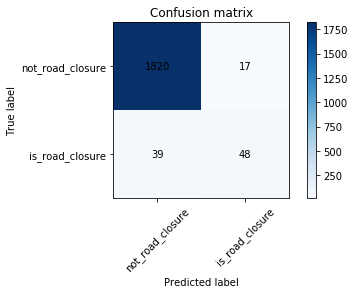

In [35]:
model_name = Log_Reg_tvec

# Generate predictions
y_pred = (model_name.predict(X_test['text'])) 
y_test.shape
y_pred.shape

# Calculate ROC AUC and Accuracy scores
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred)}")

# # Plot confusion matrix
plt.figure()
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['not_road_closure','is_road_closure']);

#### Plot ROC AUC curve

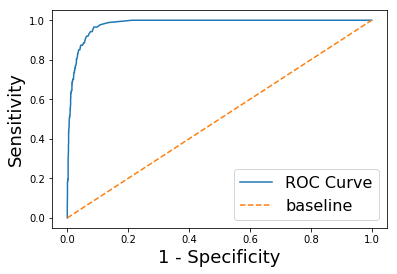

In [36]:
# calculate predicted probabilities
pred_proba = [i[1] for i in Log_Reg_tvec.predict_proba(X_test['text'])]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
# plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

### Optimize Model 3: Gradient Boosting, CountVectorizer

In [37]:
# Call function to fit the model
gb_cvec = model_fit_score(X_train['text'], y_train,         
                vect_name = 'vec',
                vect_type = CountVectorizer(),               
                model_name ='gb',          
                model_type = GradientBoostingClassifier(),
                parameters = {**params_vec, **params_gb})

# Print Training and Test scores 
print(f"Train set Score: \n {gb_cvec.score(X_train['text'], y_train)}")
print(f"Test set Score: \n {gb_cvec.score(X_test['text'], y_test)}")

For model: gb
----------------------------------------
The best parameters are: 
 {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 2, 'gb__n_estimators': 200, 'vec__max_df': 0.8, 'vec__max_features': 200, 'vec__min_df': 0.01, 'vec__ngram_range': (1, 2), 'vec__stop_words': ['should', 'during', 'amoungst', 'also', 'keep', 'on', 'moreover', 'three', 'un', 'other', 'six', 'when', 'together', 'five', 'amount', 'wherever', 'hereafter', 'might', 'neither', 'whereby', 'by', 'hereupon', 'interest', 'same', 'etc', 'who', 'next', 'toward', 'forty', 'ourselves', 'which', 'go', 'anywhere', 'hence', 'you', 'hasnt', 'are', 'con', 'become', 'him', 'am', 'eleven', 'most', 'elsewhere', 'these', 'whether', 're', 'give', 'front', 'within', 'name', 'part', 'and', 'up', 'while', 'do', 'somehow', 'thus', 'move', 'since', 'cannot', 'none', 'one', 'due', 'yet', 'whither', 'to', 'done', 'inc', 'that', 'towards', 'now', 'nobody', 'everything', 'being', 'once', 'a

### Optimize Model 4: Gradient Boosting, TfidfVectorizer

In [38]:
# Call function to fit the model
gb_tvec = model_fit_score(X_train['text'], y_train,         
                vect_name = 'vec',
                vect_type = TfidfVectorizer(),               
                model_name ='gb',          
                model_type = GradientBoostingClassifier(),
                parameters = {**params_vec, **params_gb})

# Print Training and Test scores 
print(f"Train set Score: \n {gb_tvec.score(X_train['text'], y_train)}")
print(f"Test set Score: \n {gb_tvec.score(X_test['text'], y_test)}")

For model: gb
----------------------------------------
The best parameters are: 
 {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 2, 'gb__n_estimators': 200, 'vec__max_df': 0.8, 'vec__max_features': 200, 'vec__min_df': 0.01, 'vec__ngram_range': (1, 2), 'vec__stop_words': ['should', 'during', 'amoungst', 'also', 'keep', 'on', 'moreover', 'three', 'un', 'other', 'six', 'when', 'together', 'five', 'amount', 'wherever', 'hereafter', 'might', 'neither', 'whereby', 'by', 'hereupon', 'interest', 'same', 'etc', 'who', 'next', 'toward', 'forty', 'ourselves', 'which', 'go', 'anywhere', 'hence', 'you', 'hasnt', 'are', 'con', 'become', 'him', 'am', 'eleven', 'most', 'elsewhere', 'these', 'whether', 're', 'give', 'front', 'within', 'name', 'part', 'and', 'up', 'while', 'do', 'somehow', 'thus', 'move', 'since', 'cannot', 'none', 'one', 'due', 'yet', 'whither', 'to', 'done', 'inc', 'that', 'towards', 'now', 'nobody', 'everything', 'being', 'once', 'a

#### Print confusion matrix

ROC AUC score: 0.8793416302191854


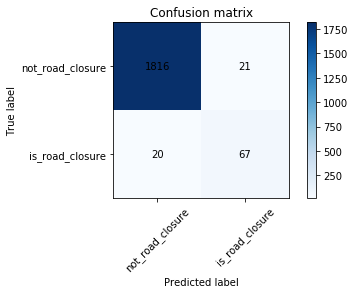

In [39]:
model_name = gb_tvec

# Generate predictions
y_pred = (model_name.predict(X_test['text'])) 
y_test.shape
y_pred.shape

# Calculate ROC AUC and Accuracy scores
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred)}")

# # Plot confusion matrix
plt.figure()
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['not_road_closure','is_road_closure']);


#### Plot ROC AUC curve

In [ ]:
# calculate predicted probabilities
pred_proba = [i[1] for i in gb_tvec.predict_proba(X_test['text'])]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
# plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## Predict, evaluate, and score the best model

### Apply SMOTE to the best model - , GradientBoosting, Tfidf Vectorizer

In [48]:
# from https://www.kaggle.com/qianchao/smote-with-imbalance-data    
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 262
Before OverSampling, counts of label '0': 5507 



In [49]:
# Instantiate TfidfVectorizer
tvec = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1,2), max_features=5_000)   

gb_Smote =GradientBoostingClassifier(
                        learning_rate=0.1, max_depth=3, min_samples_leaf=1,
                        min_samples_split=2, n_estimators=100)

sm = SMOTE(kind='regular', sampling_strategy=0.9, k_neighbors=7)

In [50]:
#1 Fit and transform Count Vectorizer
tvec_words = pd.DataFrame(tvec.fit_transform(X_train['text']).toarray(), columns=tvec.get_feature_names())

In [51]:
#2 Fit SMOTE
X_train_res, y_train_res = sm.fit_sample(tvec_words, y_train.ravel())
# X_train_res, y_train_res = sm.fit_sample(tvec_words, y_train.ravel())

In [52]:
X_train_res.shape

(10463, 5000)

In [53]:
len(y_train_res)

10463

In [54]:
#3 Fit Gradient Boosting
gb_Smote.fit(X_train_res, y_train_res)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [59]:
#export final tvec and gb model using pickle
import pickle
filename = './gb_model.sav'
pickle.dump(gb_Smote, open(filename, 'wb'))

In [60]:
filename = './tvec.sav'
pickle.dump(tvec, open(filename, 'wb'))

In [55]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))


After OverSampling, the shape of train_X: (10463, 5000)
After OverSampling, the shape of train_y: (10463,) 

After OverSampling, counts of label '1': 4956
After OverSampling, counts of label '0': 5507


In [56]:
# 4 Transform X_test
X_test_tvec = tvec.transform(X_test['text'])

In [57]:
# Score model
gb_Smote.score(X_test_tvec, y_test)

0.9797297297297297

#### Print confusion matrix

ROC AUC score: 0.9510602619212984


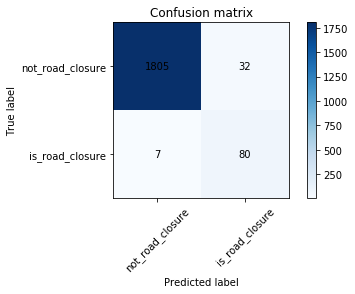

In [58]:
model_name = gb_Smote

# Generate predictions
y_pred = (model_name.predict(X_test_tvec)) 
y_test.shape
y_pred.shape

# Calculate ROC AUC and Accuracy scores
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred)}")

# # Plot confusion matrix
plt.figure()
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['not_road_closure','is_road_closure']);

#### Plot ROC AUC curve

In [ ]:
##### calculate predicted probabilities
pred_proba = [i[1] for i in Log_Reg_Smote.predict_proba(X_test_tvec)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
# plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

#### Validate on live tweets

In [ ]:
# read test file
data_test = pd.read_csv ('./Live Twitter Scraping/third_live_tweet_test.csv')

In [ ]:
data_test.shape

In [ ]:
data_test.head()

In [ ]:
# split date into date and time
data_test['time'] = data_test['time'].map(lambda x: str(x.split('+')[0]))

# convert object to datetime object
data_test['time'] = pd.to_datetime(data_test['time'])

In [ ]:
# drop columns 'Unnamed: 0 'and 'geo'; geo has all null values; hashtags has 50% null values
data_test.drop(columns = ['Unnamed: 0', 'id', 'time', 'place'], inplace=True)

In [ ]:
# Change case of all words to lower
data_test['text'] = [i.lower() for i in data_test['text']]

In [ ]:
# Remove references to indvidual accounts starting with @
data_test['text'] = [re.sub(r'@[A-z0-9]*', r' ', i) 
                    for i in data_test['text']];

In [ ]:
# Use Regular Expressions to remove all punctuations 
data_test['text'] = [re.sub('[^A-Za-z0-9#]+', ' ', i) 
                    for i in data_test['text']];

In [ ]:
# Drop duplicates
data_test.drop_duplicates(subset=['text'],inplace=True )

In [ ]:
# Initialize Lemmatizer
lm = WordNetLemmatizer()

In [ ]:
# Lemmatize the string and then join it back
data_test['text'] = [" ".join([lm.lemmatize(w) for w in i.split()]) 
                   for i in data_test['text']];

In [ ]:
data_test['y_pred_filter'] = data_test['text'].map(lambda x: 1 if ((any(word in x for word in word_list1))
                                                           & (any(word in x for word in word_list2))
                                                           & (not any(word in x for word in not_word_list))
                                                          ) else 0)


In [ ]:
data_test['y_pred_filter'].value_counts()

In [ ]:
# Generate predictions
data_test['y_pred'] = (Log_Reg_Smote.predict(data_test_tvec['text'])) 

In [ ]:
data_test['y_pred'].value_counts()

In [ ]:
# write predictions to a csv file
data_test.to_csv('./Preds_third_live_tweet_test04242019AM.csv', header = True)